# Проект по курсу "Прогнозы и предсказания" (Машинное обучение)

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с пользователями на основе аналитических данных.

Распространённая проблема фитнес-клубов и других сервисов — отток клиентов. 
Для фитнес-центра можно считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал.

Чтобы бороться с оттоком, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество анкет пользователей. Задача — провести анализ и подготовить план действий по удержанию клиентов.

### Шаг 1. Загрузить данные

«Культурист-датасаентист» предоставил сведения в csv-файлах. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. 

##### Набор данных включает следующие поля:
- 'Churn' — факт оттока в текущем месяце;
##### Текущие поля в датасете:
Данные пользователя за предыдущий до проверки факта оттока месяц:
- 'gender' — пол
- 'Near_Location' — проживание или работа в районе, где находится фитнес-центр
- 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
- 'Phone' — наличие контактного телефона
- 'Age' — возраст
- 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)
##### Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента
- 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
- 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)
- 'Group_visits' — факт посещения групповых занятий
- 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента
- 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц
- 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from matplotlib import pyplot
from matplotlib import rcParams

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
fitness = pd.read_csv('/datasets/gym_churn.csv')
fitness.shape

(4000, 14)

In [4]:
fitness.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [5]:
fitness.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


In [6]:
fitness.duplicated().sum()

0

4000 строк, 14 столбцов. Ни пропусков, ни дубликатов на первый взгляд нет.

### Исследовательский анализ данных (EDA)
- Есть ли в датасете отсутствующие признаки, изучить средние значения и стандартные отклонения;
- Проанализировать средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался;
- Построить столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);
- Построить матрицу корреляций и отобразить её.

Часть столбцов в нашем датасете категориальные (более того - бинарные, принимают значения 0 или 1). Это 'gender' (видимо, 1 - это мужчина, 0 - женщина, хотя в этом можно усмотреть некоторый сексизм )), 'Near_Location' — проживание или работа поблизости от фитнес-центра, 'Partner' — сотрудник компании-партнёра клуба, Promo_friends — факт первоначальной записи в рамках акции «приведи друга», 'Phone' — наличие контактного телефона, 'Group_visits' — факт посещения групповых занятий и 'Churn' — факт оттока в текущем месяце.

По факту они булевые, но оставим их int, это может быть удобно, например, при подсчете количества строк в датафрейме, для которых один из признаков равен 1.

In [7]:
fitness['Churn'].sum()

1061

Всего бросило занятия более 25% выборки. Не очень хорошо.

In [8]:
features = list(fitness)
features.remove('Churn')
features

['gender',
 'Near_Location',
 'Partner',
 'Promo_friends',
 'Phone',
 'Contract_period',
 'Group_visits',
 'Age',
 'Avg_additional_charges_total',
 'Month_to_end_contract',
 'Lifetime',
 'Avg_class_frequency_total',
 'Avg_class_frequency_current_month']

In [9]:
# списки признаков типов real и bool
features_float = {'Age', 'Avg_additional_charges_total', 'Month_to_end_contract', 'Lifetime', 'Avg_class_frequency_total', 'Avg_class_frequency_current_month'}
features_bool = {'gender', 'Near_Location', 'Partner', 'Promo_friends', 'Phone', 'Group_visits'}

In [11]:
fitness.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [12]:
fg = fitness.groupby('Churn')

#for column in features:
#    print(column)
#    print(fg[column].mean())
#    print()

fitness.groupby('Churn').mean() # )))

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Очень интересные результаты. Клиенты, которые босают занятия, посещают зал вдвое реже, чем те, кто продолжают заниматься, они занимаются около 1го месяца, абонемент у них, в основном, на 1 месяц (редко 3), и они на 3 года моложе!

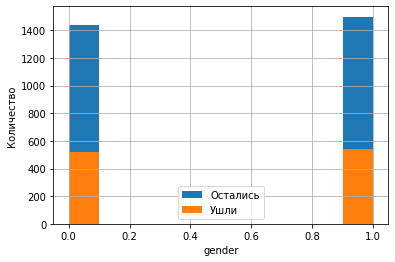

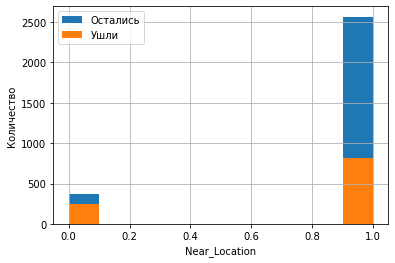

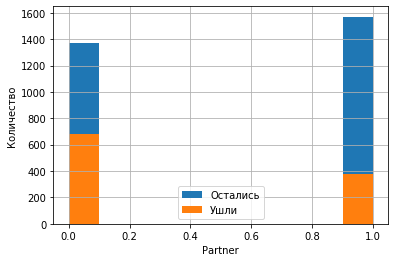

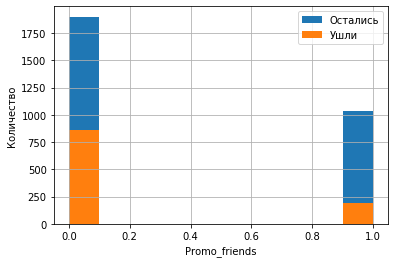

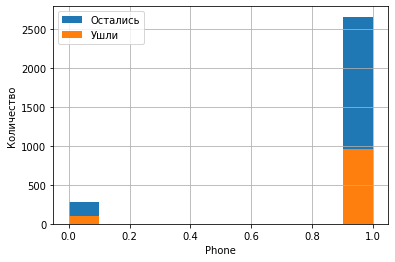

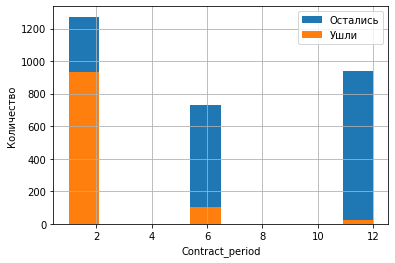

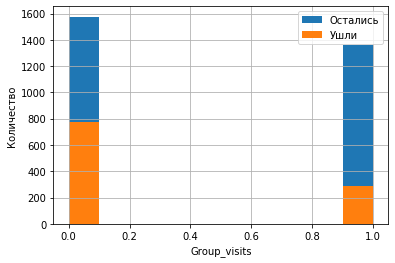

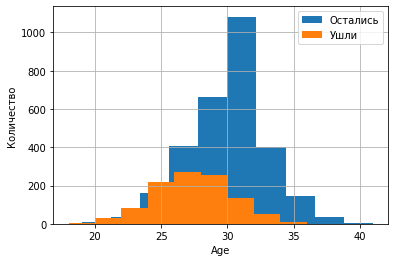

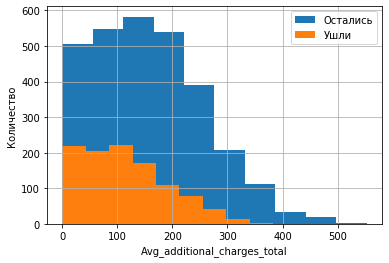

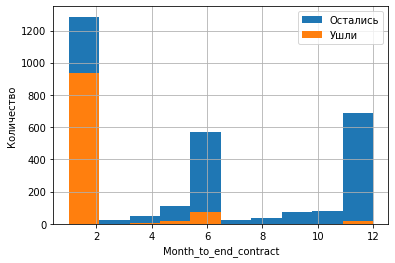

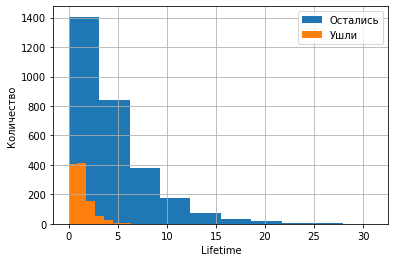

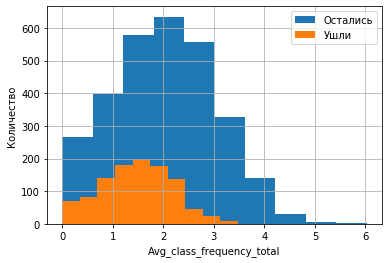

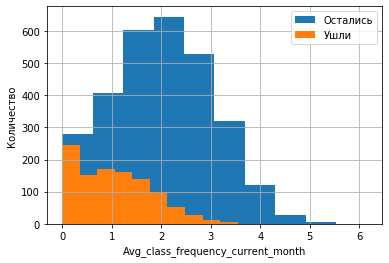

In [13]:
for column in features:
    plt.xlabel(column)
    plt.ylabel('Количество')
    fg[column].hist()
    labels= ['Остались', 'Ушли']
    plt.legend(labels)
    plt.show()

Что можно сказать по этим гистограммам? Бросают клиенты, у которых походит к концу их абонемент. Почму они не хотят с нами оставаться дальше?
Возраст бросающих немного ниже, чем у тех, кто предпочтает остаться.
У большинства - месячные абонементы. То есть - попробовали и не понравилось.  Это подтверждает и распределение признака Lifetime - у большинства это 1-2 месяца.


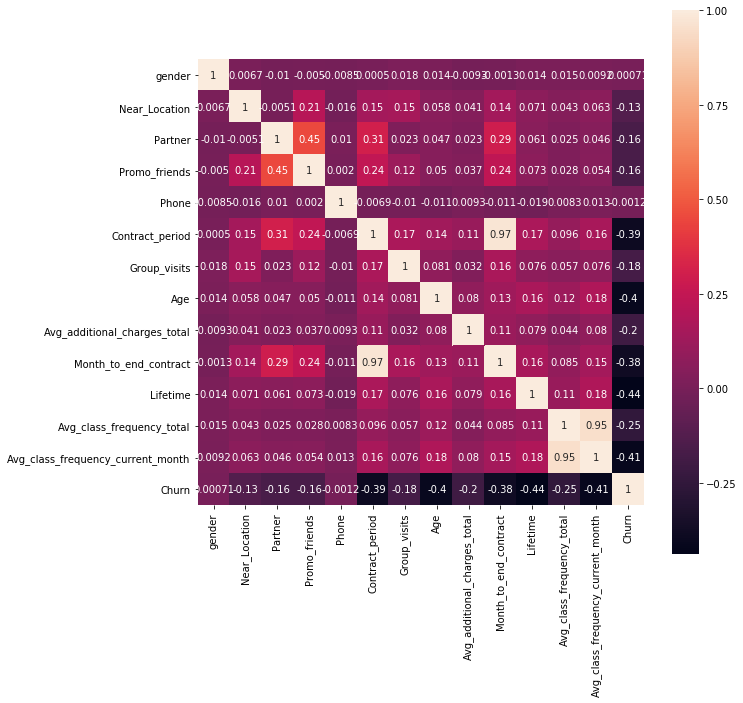

In [14]:
# корреляционная матрица
corr_m = fitness.corr()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_m, square = True, annot = True,  ax=ax);

Очень сильно коррелируют поля 'Contract_period' — длительность текущего действующего абонемента и 'Month_to_end_contract' — срок до окончания текущего действующего абонемента, а также 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента и 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц - это понятно, клиены обычно придерживаются своего сложившегося графика посещений.

Но, так как имеем дело не с линейной регрессией, то коррелирующие между собой признаки удалять не нужно.

### Шаг 3. Построить модель прогнозирования оттока пользователей
Построить модель бинарной классификации пользователей, где целевой признак — факт оттока пользователя в следующем месяце:
- Разбить данные на обучающую и валидационную выборку функцией train_test_split().
- Обучить модель на train-выборке двумя способами:
    - логистической регрессией
    - случайным лесом
- Оценить метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравнить по ним модели. Какая модель показала себя лучше на основании метрик?

In [15]:
#разделим данные на признаки и целевую переменную
X = fitness.drop('Churn', axis=1)
y = fitness['Churn']

#разделяем модель на обучающую и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [16]:
# обучаем StandartScaler
scaler = StandardScaler()
scaler.fit(X_train)

# Стандартизируем обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [17]:
# функция вывода всех нужных метрик
def print_all_metrics(y_true, y_pred, y_proba, title = 'Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

# алгоритм модели логистической регрессии
lr_model = LogisticRegression(random_state = 0)
# обучение 
lr_model.fit(X_train_st, y_train)
# прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]
# метрики
print_all_metrics(y_test, lr_predictions, lr_probabilities , title='Метрики для модели логистической регрессии:')


Метрики для модели логистической регрессии:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83


In [18]:
# алгоритм модели случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)  # Ваш код здесь
# обучение модели
rf_model.fit(X_train_st, y_train)
# прогнозы
rf_predictions = rf_model.predict(X_test_st) # Ваш код здесь
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1] # Ваш код здесь
# метрики
print_all_metrics(y_test, rf_predictions, rf_probabilities, title = 'Метрики для модели случайного леса:')


Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.81


Значения метрик получились довольно близкими для обеих моделей. Доля правильных ответов вообще одинакова - 0.92 и для логистической регресии, и для случайного леса. Это вроде бы неплохо, но в нашей выборке баланс классов смещен в сторону клиентов, остающихся в зале 74%/26% и  это могло повлиять на высокий показатель Accuracy.

А вот точность и полнота хоть чуть-чуть, но лучше у модели логистической регрессии.

### Шаг 4. Провести кластеризацию пользователей
Провести кластеризацию объектов (пользователей):
- Стандартизировать данные.
- Построить матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуйте дендрограмму. На основании полученного графика предположить, какое количество кластеров можно выделить.
- Обучить модель кластеризации на основании алгоритма K-Means и спрогнозировать кластеры клиентов.
- Проанализировать средние значения признаков для кластеров. Можно ли сразу что-то заметить?
- Построить распределения признаков для кластеров. Можно ли что-то заметить по ним?
- Для каждого полученного кластера посчитать долю оттока. Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?

In [19]:
X.head(3)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502


In [20]:
# стандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# строим матрицу расстояний
linked = linkage(X_sc, method = 'ward')

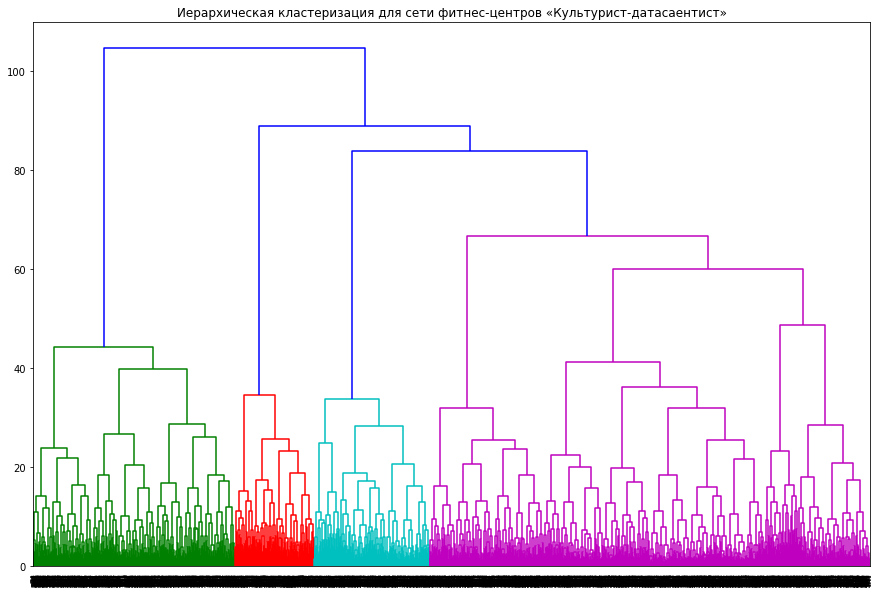

In [21]:
# строим дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация для сети фитнес-центров «Культурист-датасаентист»')
plt.show()

Предложенное оптимальное число кластеров - 4

#### Обучить модель кластеризации на основании алгоритма K-Means и спрогнозировать кластеры клиентов.

In [22]:
# задаём модель k_means с числом кластеров 4
km = KMeans(n_clusters=4, random_state = 0)
# прогнозируем кластеры для наблюдений
labels = km.fit_predict(X_sc) 

# сохраняем метки кластера в поле нашего датасета
fitness['cluster_km'] = labels
fitness.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn,cluster_km
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0,3
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0,1
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0,3
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0,1


#### Проанализировать средние значения признаков для кластеров. 

In [23]:
# количество клиентов по кластерам
clusters_quant = fitness.groupby('cluster_km', as_index=False).count()[['cluster_km', 'gender']].rename(columns={'gender': 'clients_quant'})

In [24]:
clusters_quant

,cluster_km,clients_quant
0,0,386
1,1,1479
2,2,1057
3,3,1078


In [25]:
clusters_mean = fitness.groupby('cluster_km').mean()
clusters_mean

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster_km,,,,,,,,,,,,,,
0,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,1.723967,0.266839
1,0.486815,0.759297,0.381339,0.190669,1.0,1.899256,0.292765,28.048005,129.704525,1.805274,2.235294,1.204610,0.951590,0.559838
2,0.544939,0.861873,0.343425,0.205298,1.0,2.403027,0.447493,29.989593,157.358764,2.239357,4.704825,2.724796,2.711132,0.092715
3,0.503711,0.940631,0.777365,0.572356,1.0,10.697588,0.536178,29.912801,161.363032,9.768089,4.730056,1.983884,1.975592,0.029685


Что можно сказать, глядя на средние значения признаков для кластеров? Половой баланс во всех кластерах примерно 50/50 с незначительными отклонениями. Средний возраст во всех кластерах 28-30 лет. Для всех кластеров у подавялющего большинства клиентов зал находится по соседству с местом работы/проживания.
- В кластере №0 первое, что бросается в глаза - никто (!) из них не предоставил контактный телефон (в остальных кластерах это сделали все)! И посещают зал достаточно давно (около 4х месяцев), и до конца действи абонемента далеко и абонемент на 3-6 месяцев, частота посещения средняя на фоне других кластеров, хотя денег на доп.услуги тратят мало. Неужели признак телефона настолько определяющ?
- Кластер №1. Самый низкий процент воспользовавшихся промо предложением, по партнерскому - второй снизу результат. Абонемент на короткий срок (1-2 месяца), в зал ходят примерно 2-3 месяца, самый низкий процент посещения групповых занятий, самые низкие траты на дополнительные услуги, самая низная частота посещений в текущем месяце и вообще. Похоже, что эти ребята купили абонемент на 1-3 месяца на пробу (или им его подарили?) и больше, чем половине из них решительно ничего не нравится. Грустно, что это еще и самый молодой кластер - на 1-2 года младше остальных. Возможно, нам нужно меняться, чтобы привлечь больше молодежи, а возможно, что вкус к регулярным занятиям спортом приходит позже. 
- Кластер №2. Самая возрастная группа. Партнерскими и промо предложениями пользуются мало, абонемент ненадолго и находтся в середине своего срока. При этом ходят чаще всех - почти трижды в неделю. Взяли абонемент на недолгий срок и выжимают из него максимум!
- Кластер №3. Самый высокий процент обитающих или работающих по соседству, самый высокий процент, воспользовавшихся партнерским или промо предложениями. Предпочитают длительные абонементы, больше всех посещают групповые занятия, больше всех тратят в зале на дополнительные услуги, при этом ходят реже всех - даже не каждую неделю. 

#### Построить распределения признаков для кластеров.

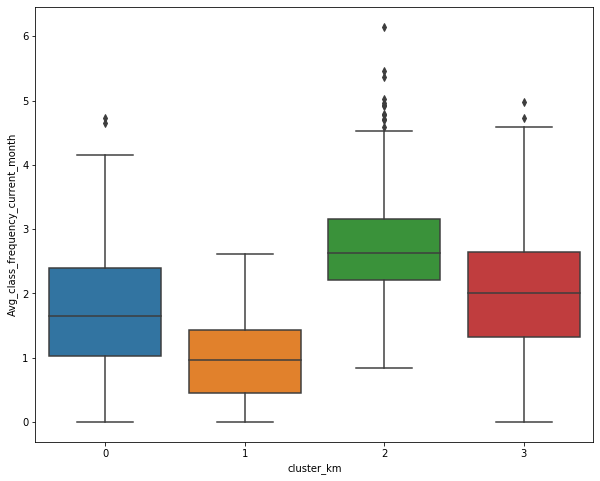

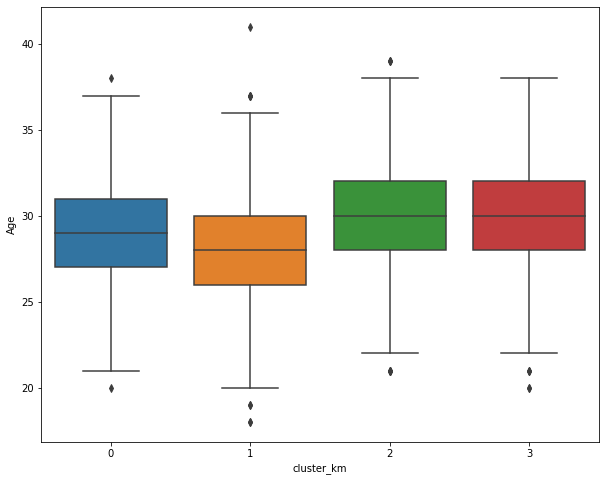

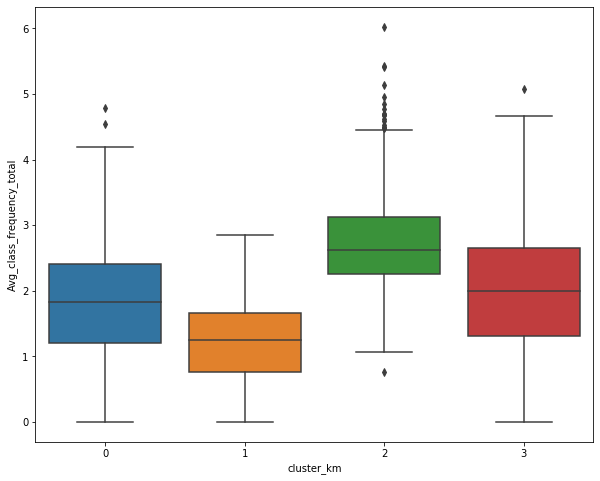

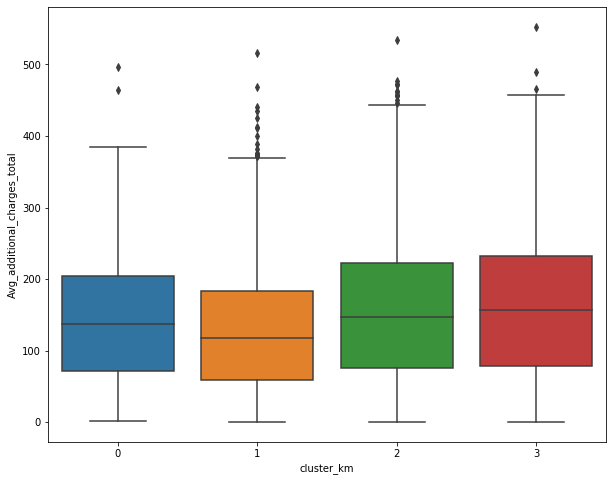

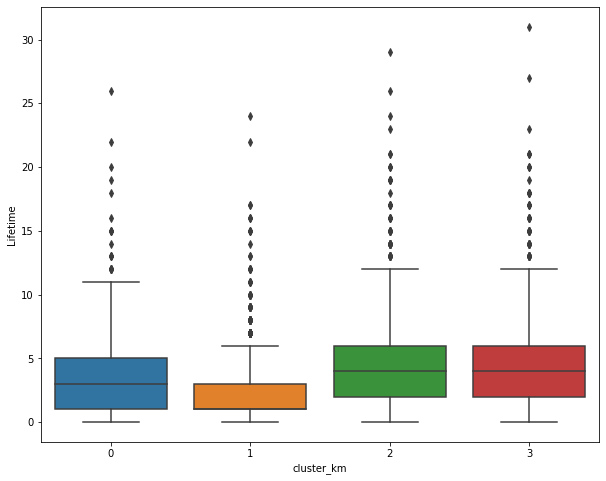

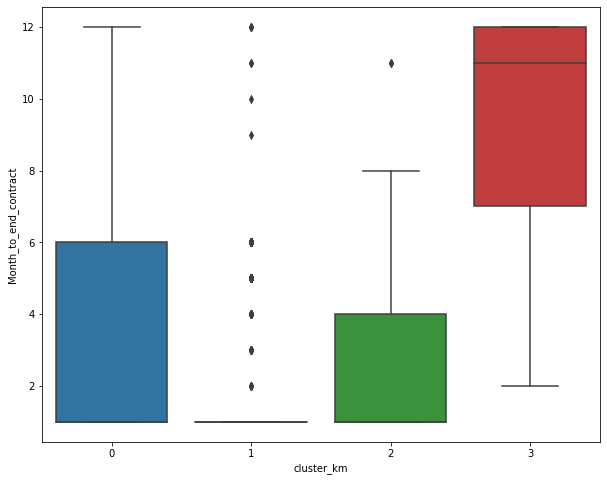

In [26]:
# строим для непрерывных признаков  
for column in features_float:
    rcParams['figure.figsize'] = 10, 8
    sns.boxplot(x='cluster_km', y=column,  data=fitness)
    plt.show()

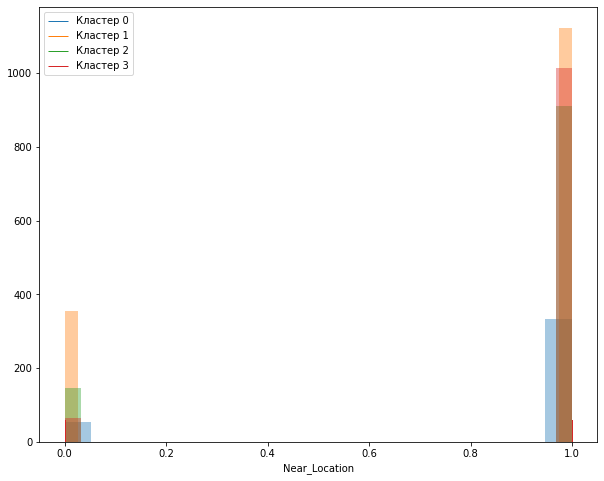

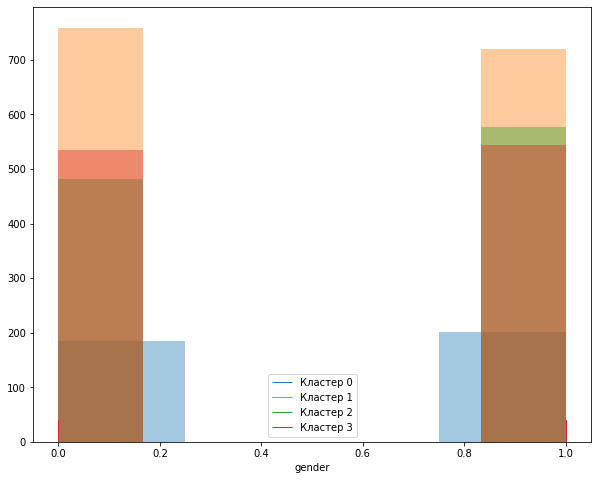

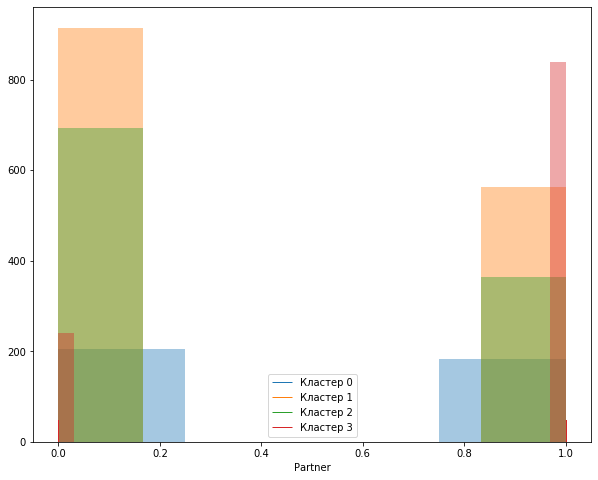

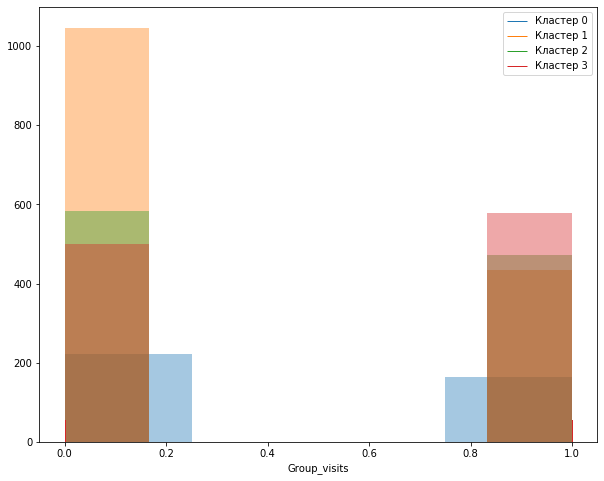

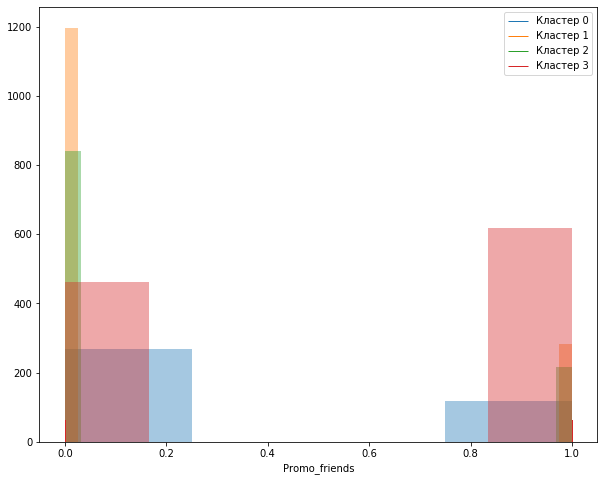

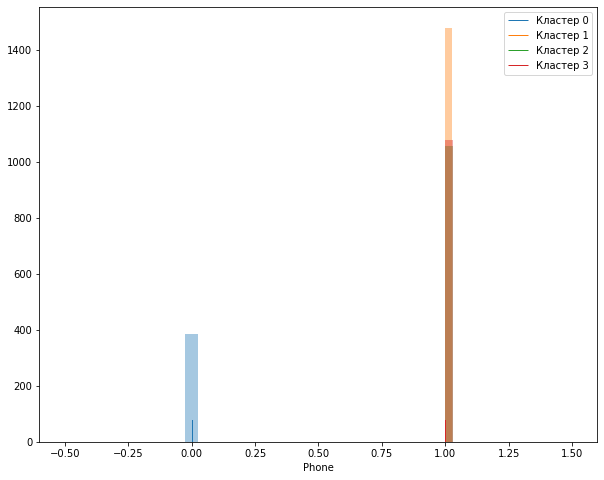

In [27]:
# строим гистограммы для категориальных признаков
for column in features_bool:
    # Sort the dataframe by target
    cluster_0 = fitness.loc[fitness['cluster_km'] == 0]
    cluster_1 = fitness.loc[fitness['cluster_km'] == 1]
    cluster_2 = fitness.loc[fitness['cluster_km'] == 2]
    cluster_3 = fitness.loc[fitness['cluster_km'] == 3]
    
    sns.distplot(cluster_0[[column]], kde=False, rug=True)
    sns.distplot(cluster_1[[column]], kde=False, rug=True)
    sns.distplot(cluster_2[[column]], kde=False, rug=True)
    sns.distplot(cluster_3[[column]], kde=False, rug=True)
    rcParams['figure.figsize'] = 10, 8
    plt.legend(labels=['Кластер 0','Кластер 1', 'Кластер 2', 'Кластер 3'])
    plt.xlabel(column)
    plt.show()
    

Графики подтверждают выводы, которые мы делали на основе таблицы со средними значениями признаков. Кластер №1 проседает по всем показателям и мы их теряем. Кластер №3 - идеальные клиенты, абонементы на полгода или год, дольше всех посещают зал, самые высокие траты. Остальные две группы более менее близки, но есть свои особенности.

#### Для каждого полученного кластера посчитать долю оттока

In [28]:
clusters_churn = fitness.groupby('cluster_km', as_index=False).agg({'Churn':'sum'})[['cluster_km', 'Churn']].rename(columns={'Churn': 'churn_quant'})

In [29]:
clusters_churn

,cluster_km,churn_quant
0,0,103
1,1,828
2,2,98
3,3,32


In [30]:
clusters_churn_percent = clusters_churn.join(clusters_quant.set_index('cluster_km'), on='cluster_km')

In [31]:
clusters_churn_percent

,cluster_km,churn_quant,clients_quant
0,0,103,386
1,1,828,1479
2,2,98,1057
3,3,32,1078


In [32]:
clusters_churn_percent['percent'] = (clusters_churn_percent['churn_quant'] / clusters_churn_percent['clients_quant'])
clusters_churn_percent

,cluster_km,churn_quant,clients_quant,percent
0,0,103,386,0.266839
1,1,828,1479,0.559838
2,2,98,1057,0.092715
3,3,32,1078,0.029685


Самый провальный для нашего бизнеса - кластер №2 - 56%-й отток. Не радует кластер №0 с оттоком в 26%. Остальные два кластера демонстрируют высокую лояльность - у кластера №2 отток 9%,  у №3 - и вовсе меньше 3%.

### Шаг 5. Сформулировать выводы и сделать базовые рекомендации по работе с клиентами
Сформулировать основные выводы и предложить рекомендации для стратегии взаимодействия с пользователями и их удержания.

На примере кластера 0, можем сказать, что если клиент не предоставляет номер телефона, то мы вероятность его потерять - больше 1/4. Это не значит, что если мы выцарапаем из клиента контактный телефон, то он останется с нами на всю жизнь. Скорее, тут обратная ситуация - телефон предоставляют клиенты, которые нам доверяют.

В двух наших самых лояльных кластерах, большинство клиентов воспользовалось партнерской скидкой или скидкой "Приведи друга". И наоборот - в кластерах с максимальным оттоком зафиксированы минимальные значение этих признаков. Стоит усилить продвижение этих программ, в первую очередь в фирмах и ЖК по соседству.

Высокую лояльность показывают клиенты, посещающие групповые программы. В таких группах завязываются дружеские отношения, что еще больше привязывает клиента к залу. Можно предложить стимулировать вовлечение в групповые занятия, например - бесплатные пробные посещения, пакетные предложения на эти тренировки и т.д.

Низкий уровень оттока наблюдается у клиентов с долгими абонементами. Если у клиента абонемент действует еще полгода, уходить он обычно не торопится. Нужно стимулировать приобретение полугодовых и годовых абонементов,  в первую очередь - значительными скидками, бесплатными посещениями групповых занятий, скидками на дополнительные услуги.

Прискорбно, что кластер, который почти поголовно покидает наш зал, является самым молодым. На удержание молодежи следует обратить внимание. Как способ удержания можно предложить ввести групповые занятия, нацеленные именно на более молодых клиентов и более активно предлагать им пользоваться скидкой "Приведи друга" - возможно в зале просто слишком клиентов 20-25 лет и им неуютно среди болеее старших посетителей. Впрочем, это тема отдельного аналитического исследования.